In [1]:
import bibtexparser
from urllib.parse import urlparse
import requests
from bs4 import BeautifulSoup
from pathlib import Path

In [13]:
def scrape_images(webpage_url, save_dir):
    try:
        # Send a GET request to the webpage
        response = requests.get(webpage_url)
        response.raise_for_status()  # Check for HTTP issues

        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find all image tags
        img_tags = soup.find_all('img')

        # Create the directory if it doesn't exist
        save_path = Path(save_dir)
        save_path.mkdir(parents=True, exist_ok=True)
        for img_tag in img_tags:
            img_url = img_tag.get('src')
            if not img_url:
                continue

            # Handle relative URLs
            if not img_url.startswith(('http:', 'https:')):
                img_url = requests.compat.urljoin(webpage_url, img_url)

            # Get the image filename
            filename = save_path / Path(img_url).name

            # Download the image
            try:
                img_response = requests.get(img_url, stream=True)
                img_response.raise_for_status()

                with filename.open('wb') as file:
                    for chunk in img_response.iter_content(1024):
                        file.write(chunk)

                print(f"Downloaded: {filename}")

            except requests.exceptions.RequestException as e:
                print(f"Failed to download {img_url}: {e}")

    except requests.exceptions.RequestException as e:
        print(f"Failed to scrape webpage: {e}")
    return True

In [3]:
path =  "/home/bartek/Kod/PD/praca_dyplomowa/dane/malpedia.bib.txt"

In [4]:
with open(path, "r", encoding="utf-8") as file:
    content = file.read()

In [5]:
library = bibtexparser.parse_string(content)

In [6]:
def bib_file_to_title_url_tuple(library_entry_fields):
    return tuple(field.value for field in library_entry_fields if field.key in ["title", "url"])

In [42]:
library.entries[0].fields

[Field(key=`author`, value=`@037`, start_line=1),
 Field(key=`title`, value=`{APT38 DYEPACK FRAMEWORK}`, start_line=2),
 Field(key=`date`, value=`2019-03-20`, start_line=3),
 Field(key=`organization`, value=`Github (649)`, start_line=4),
 Field(key=`url`, value=`https://github.com/649/APT38-DYEPACK`, start_line=5),
 Field(key=`language`, value=`English`, start_line=6),
 Field(key=`urldate`, value=`2019-12-17`, start_line=7)]

In [46]:
bib_file_to_title_url_tuple(library.entries[0].fields)

('{APT38 DYEPACK FRAMEWORK}', 'https://github.com/649/APT38-DYEPACK')

In [7]:
blacklist = ["youtube.com", "twitter.com"]

In [8]:
titles_n_links = [bib_file_to_title_url_tuple(library_entry.fields) for library_entry in library.entries if urlparse(bib_file_to_title_url_tuple(library_entry.fields)[1].replace("www.", "")).hostname not in blacklist]

In [9]:
h_tlinks = titles_n_links[:100]

In [10]:
images_path = "/home/bartek/Kod/PD/praca_dyplomowa/images"

Downloaded: /home/bartek/Kod/PD/praca_dyplomowa/images/APT38_DYEPACK_FRAMEWORK/SWIFT_Interception.png
Downloaded: /home/bartek/Kod/PD/praca_dyplomowa/images/APT38_DYEPACK_FRAMEWORK/Decompiled_Printer_detection.png
Downloaded: /home/bartek/Kod/PD/praca_dyplomowa/images/APT38_DYEPACK_FRAMEWORK/Destroying_Transaction_Records.png
Downloaded: /home/bartek/Kod/PD/praca_dyplomowa/images/APT38_DYEPACK_FRAMEWORK/Evasion.png
Downloaded: /home/bartek/Kod/PD/praca_dyplomowa/images/APT38_DYEPACK_FRAMEWORK/Interesting_Strings.png
Downloaded: /home/bartek/Kod/PD/praca_dyplomowa/images/APT38_DYEPACK_FRAMEWORK/Printer_detection.png
Downloaded: /home/bartek/Kod/PD/praca_dyplomowa/images/APT38_DYEPACK_FRAMEWORK/SQL_Statements.png
1
Downloaded: /home/bartek/Kod/PD/praca_dyplomowa/images/SapphireStealer/209464192-12ae4dab-66fc-46d5-b2e9-9e8cab25b7dd.png
Downloaded: /home/bartek/Kod/PD/praca_dyplomowa/images/SapphireStealer/209464194-7682515f-b4f4-4bd0-bf75-99d89e4ba1e4.png
2
Failed to scrape webpage: HTTPS
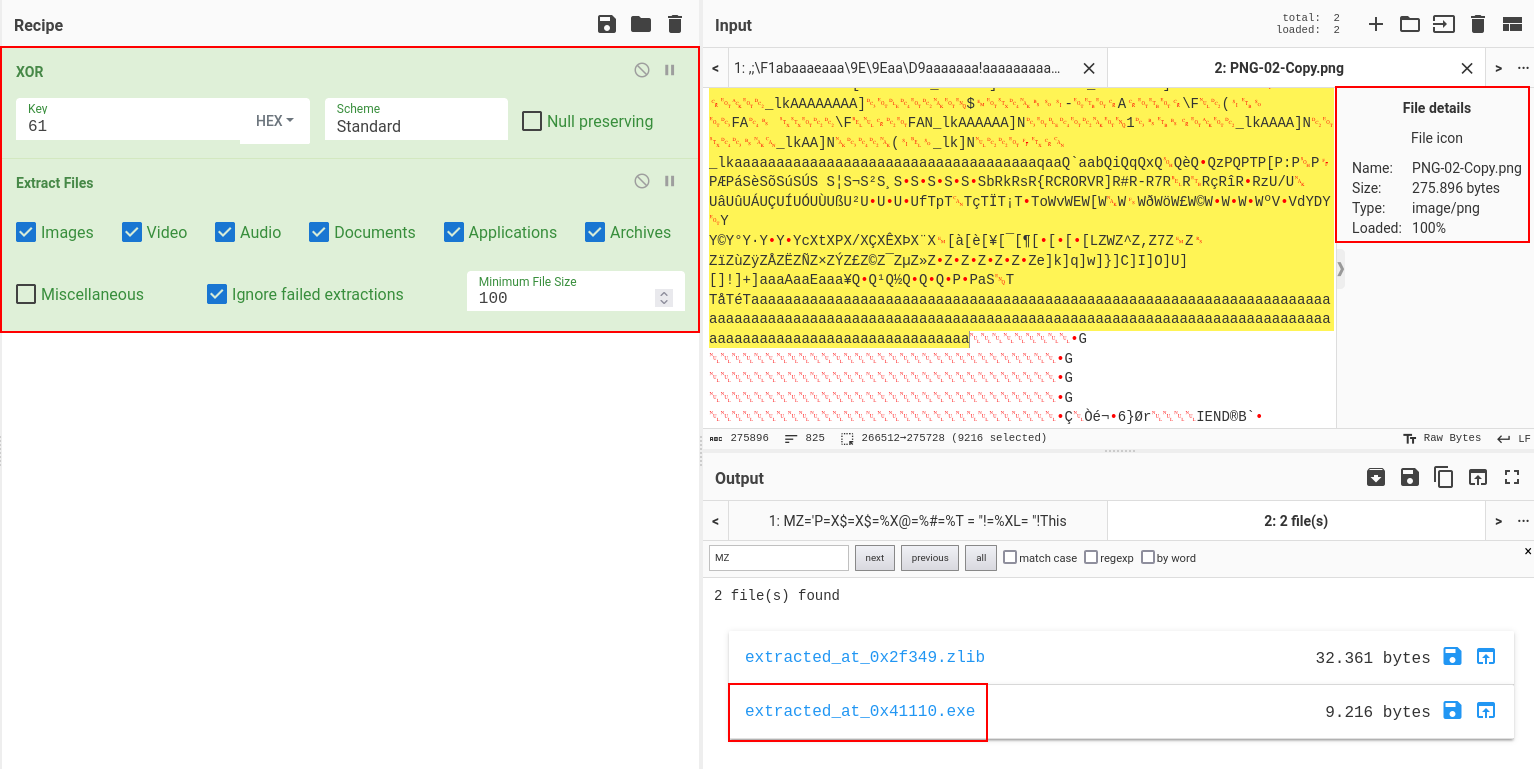
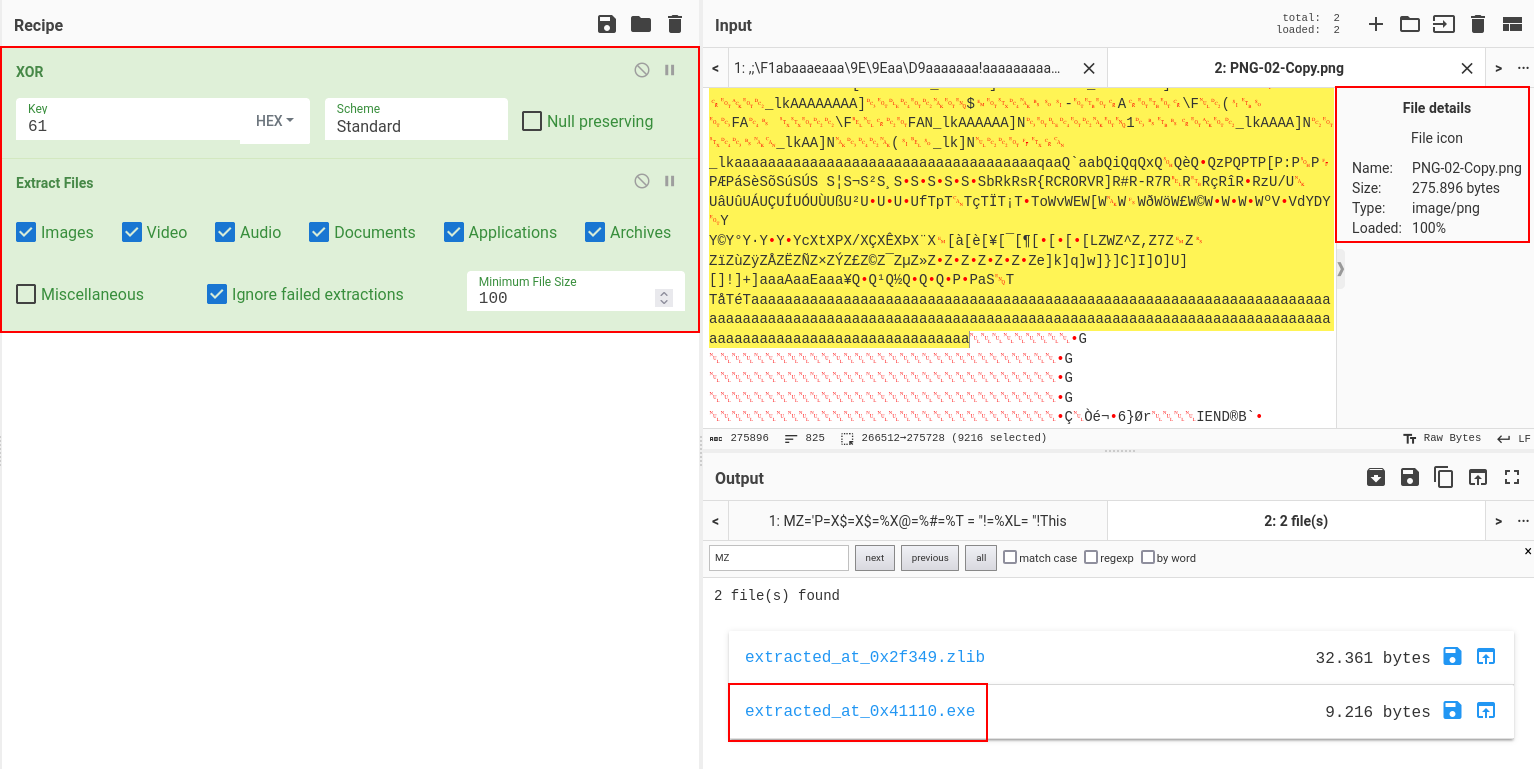

In [14]:
counter = 0
for title, url in h_tlinks:
    title = title.replace("{", "").replace("}", "").replace(" ", "_")[:30]
    try:
        counter += scrape_images(url, f"{images_path}/{title}")
        print(counter)
        if counter > 100:
            break
    except OSError as exc:
        if exc.errno == 36:
            print(exc)
            continue